In [ ]:
#default_exp data

# Data
> Basic functionalities to read the NYU dataset

In [ ]:
#export
import random
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
import mat73
from fastcore.all import *

from hydranet.utils import *

## Dataset

In [ ]:
#export
def matlab_to_np(dataset_path = 'data/nyu_depth_v2_labeled.mat'):
    "Save on npy files our dataset"
    data = mat73.loadmat(dataset_path)
    np.save("data/images", data["images"])
    np.save("data/depths", data["depths"])
    np.save("data/labels", data["labels"])

In [ ]:
#export
class Resize:
    def __init__(self, size):
        self.resize = T.Resize(size)
    def __call__(self, *args):
        return (self.resize(a) for a in args)

In [ ]:
#export
class NYUDataset:
    
    _titles=["img", "depth", "label"]
    
    def __init__(self, images, depths, labels, tfms=None, size=None):
        store_attr()
        self.resize = [Resize(size)]
        if size is not None:
            self.tfms = listify(tfms)
    
    def split(self, val_idxs=None, pct=None):
        
        if pct is not None and val_idxs is None:
            assert 0<pct<1, "Please give a percentage between 0 and 1"
            pct = int(pct*len(self))
            val_idxs = random.sample(range_of(self), pct)
        
        train_idxs = [n for n in range(self.images.shape[-1]) if n not in val_idxs]
        
        def _idx_arrays(idxs):
            arrays = [self.images, self.depths, self.labels]
            return [a[...,idxs] for a in arrays]
        
        val_data = _idx_arrays(val_idxs)
        train_data = _idx_arrays(train_idxs)
        return NYUDataset(*train_data, self.tfms, self.size), NYUDataset(*val_data, None, self.size)
        
    
    @classmethod
    def from_mat(cls, mat_file='data/nyu_depth_v2_labeled.mat'):
        matlab_to_np(mat_file)
        return cls.from_npy()
    
    @classmethod
    def from_npy(cls, dataset_path='data', tfms=None, size=None):
        images = np.load(Path(dataset_path)/"images.npy")
        depths = np.load(Path(dataset_path)/"depths.npy")            
        labels = np.load(Path(dataset_path)/"labels.npy")
        return cls(images, depths, labels,  tfms, size)

    def __getitem__(self, idx):
        timg = T.ToTensor()(self.images[..., idx])
        tdepth = torch.as_tensor(self.depths[None, :, :, idx])
        tlabel = torch.as_tensor(self.labels[None, :, :, idx].astype(np.int64))
        if self.tfms is not None:
            for t in self.resize + self.tfms:
                timg, tdepth, tlabel = t(timg, tdepth, tlabel)
        return (timg, tdepth, tlabel)
        
    def show_one(self, idx=0):
        show_images(self.__getitem__(idx), titles=self._titles)
    
    def __len__(self): return self.images.shape[-1]

    def dataloader(self, batch_size: int, num_workers: int, shuffle: bool=False, pin_memory: bool=False) -> data.DataLoader:
         return data.DataLoader(
             self,
             batch_size=batch_size,
             num_workers=num_workers,
             shuffle=shuffle,
             pin_memory=pin_memory,
         )

In [ ]:
ds = NYUDataset.from_npy(size=240)

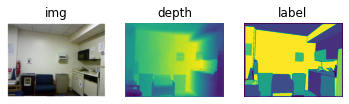

In [ ]:
ds.show_one()

In [ ]:
ds[0][0].shape

torch.Size([3, 240, 320])

## Transforms

In [ ]:
#export
import random
class RandomAugment:
    def __init__(self, crop_size, hflip=True, vflip=False, rotation=8):
        store_attr()
        
    def __call__(self, *images):
        
        # Random Rotation
        angle = random.randrange(0, self.rotation)
        images = [TF.rotate(im, angle) for im in images]
        
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(
            images[0], output_size=self.crop_size)
        images = [TF.crop(im, i, j, h, w) for im in images]   
        

        
        # Random horizontal flipping
        if random.random() > 0.5 and self.hflip:
            images = [TF.hflip(im) for im in images]

        # Random vertical flipping
        if random.random() > 0.5 and self.vflip:
            images = [TF.vflip(im) for im in images]
            
        # Random Gamma
        gamma = random.uniform(0.5,1.5)        
        images[0] = TF.adjust_gamma(images[0], gamma) 

        return images
    

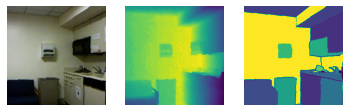

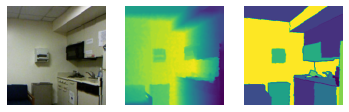

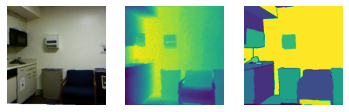

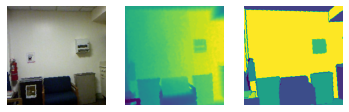

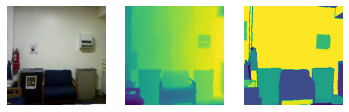

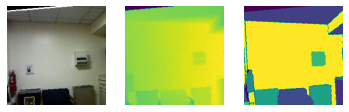

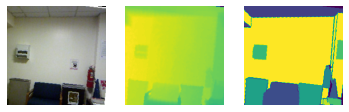

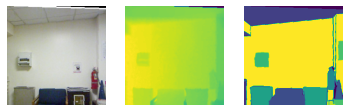

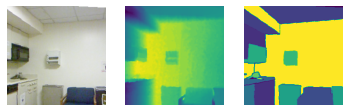

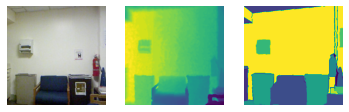

In [ ]:
ra = RandomAugment(crop_size=(200, 200))
for _ in range(10):
    show_images(ra(*ds[0]))

In [ ]:
aug_ds = NYUDataset.from_npy(size=256, tfms=RandomAugment(crop_size=(200,200)))

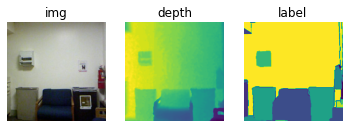

In [ ]:
aug_ds.show_one()

## Export -

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data.ipynb.
Converted 02_layers.ipynb.
Converted 03_models.ipynb.
Converted 04_trainer.ipynb.
Converted 10_basline_train.ipynb.
